# COVID-19 modelamiento Santiago, Chile
Autor: Taco de Wolff\
Fecha: 10 abril 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epidemic import *

model = ModelReport2()

## Sin estrategía

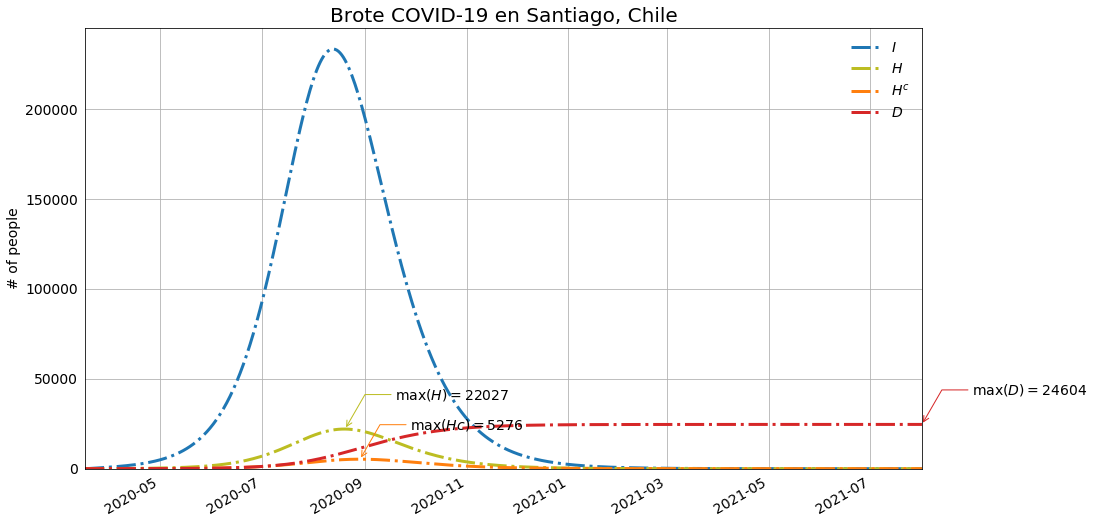

Parameter,Value,Date
R effective,1.76,2020-03-17
R effective,0.51,2021-08-01
max(I),233317,2020-08-13
max(H),22027,2020-08-20
max(Hc),5276,2020-08-29
max(D),24604,2021-08-01


In [2]:
t0 = np.datetime64('2020-03-17')
y0 = {'S': 5.624e6, 'E': 129, 'Im': 1799, 'I': 29, 'H': 0, 'Hc': 0, 'R': 0, 'D': 0}

def α(t, data, target=None):
    return 1.0

def params(t, data):
    return {
        'βE': α(t,data,'E')*0.062015625,
        'βIm': α(t,data,'Im')*0.12403125,
        'βI': α(t,data,'I')*0.165375,
        'βH': α(t,data,'H')*0.0,
        'βHc': α(t,data,'Hc')*0.0,
        'γE': 0.2,
        'γIm': 0.1,
        'γI': 0.1,
        'γH': 0.1666,
        'γHc': 0.1,
        'μb': 3.57e-5,
        'μd': 1.57e-5,
        'φEI': 0.50,
        'φIR': 0.85,
        'φHR': 0.85,
        'φD': 0.50,
    }

epidemic = Epidemic(model, t0, tmax=np.datetime64('2021-08-01'))
epidemic.run(y0, params)
epidemic.run_parameter('R_effective', model.R_effective)
epidemic.plot('Brote COVID-19 en Santiago, Chile', cols=['I', 'H', 'Hc', 'D'], max=['H', 'Hc', 'D'])
epidemic.print_stats()

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile (parámetros)', cols=['R_effective'])

## Estrategia 1: lockdown

In [ ]:
λ0 = np.datetime64('2020-04-06')
λL = λ0 + np.timedelta64(2,'W')
λCTI = λ0 + np.timedelta64(52,'W')
def α(t, data, target=None):
    if t >= λ0 and t < λL:
        return 0.25
    return 1.0

epidemic.run(y0, params)
epidemic.run_parameter('R_effective', model.R_effective)
epidemic.plot('Brote COVID-19 en Santiago, Chile: estrategia 1', cols=['I', 'H', 'Hc', 'D'], max=['H', 'Hc', 'D'])
epidemic.print_stats()

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile: estrategia 1 (parámetros)', cols=['R_effective'])

## Estrategia 2a: CTI moderate

In [ ]:
def α(t, data, target=None):
    if target in ['E', 'Im'] and t >= λ0 and t < λCTI:
        return 0.75
    return 1.0

epidemic.run(y0, params)
epidemic.run_parameter('R_effective', model.R_effective)
epidemic.plot('Brote COVID-19 en Santiago, Chile: estrategia 2a', cols=['I', 'H', 'Hc', 'D'], max=['H', 'Hc', 'D'])
epidemic.print_stats()

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile: estrategia 2a (parámetros)', cols=['R_effective'])

## Estrategia 2b: CTI high

In [ ]:
def α(t, data, target=None):
    if target in ['E', 'Im'] and t >= λ0 and t < λCTI:
        return 0.5
    return 1.0

epidemic.run(y0, params)
epidemic.run_parameter('R_effective', model.R_effective)
epidemic.plot('Brote COVID-19 en Santiago, Chile: estrategia 2b', cols=['I', 'H', 'Hc', 'D'], max=['H', 'Hc', 'D'])
epidemic.print_stats()

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile: estrategia 2b (parámetros)', cols=['R_effective'])

## Estrategia 3: combinacíon de estrategía 1 y 2b

In [ ]:
def α(t, data, target=None):
    if t >= λ0:
        if t < λL:
            return 0.25
        elif t < λCTI and target in ['E', 'Im']:
            return 0.5
    return 1.0

epidemic.run(y0, params)
epidemic.run_parameter('R_effective', model.R_effective)
epidemic.plot('Brote COVID-19 en Santiago, Chile: estrategia 3', cols=['H', 'Hc'], max=['H', 'Hc'])
epidemic.print_stats()

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile: estrategía 3 (parámetros)', cols=['R_effective'])

## Estrategia 4: feedback

In [ ]:
cuarantena = False
def α(t, data, target=None):
    global cuarantena
    
    y = data[-1]
    pormil = ((y['I'] + y['H'] + y['Hc']) / model.N(t, data)) * 100000
    if not cuarantena and pormil > 50.0:
        cuarantena = True
    elif cuarantena and pormil < 25.0:
        cuarantena = False
    
    if cuarantena:
        return 0.25
    return 1.0

epidemic.run(y0, params)
epidemic.run_parameter('R_effective', model.R_effective)
epidemic.run_parameter('α', α)
epidemic.plot('Brote COVID-19 en Santiago, Chile: estrategia feedback', cols=['I', 'H', 'Hc'], max=['I', 'H', 'Hc'])
epidemic.print_stats()

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile: estrategia 4 (parámetros)', cols=['R_effective'])

In [ ]:
epidemic.plot_params('Brote COVID-19 en Santiago, Chile: estrategia 4 (parámetros)', cols=['α'])

## UCI por días en cuarantena

In [ ]:
umbral_superior = 50.0
umbral_inferior = 25.0

cuarantena = False
def α(t, data, target=None):
    global cuarantena
    
    y = data[t]
    indicador = 0
    N = model.N(t, data)
    if N != 0:
        indicador = ((y['I_cases'] + y['H_cases'] + y['Hc_cases']) / N) * 100000
    if not cuarantena and indicador > umbral_superior:
        cuarantena = True
    elif cuarantena and indicador < umbral_inferior:
        cuarantena = False
    
    if cuarantena:
        return 0.25
    return 1.0

def días_cuarantena(data):
    días = 0
    for t, α in data['α'].iteritems():
        días += 0 if α == 1.0 else 1
    return días

xs = np.concatenate([np.arange(10.0, 200.0, 10.0), np.arange(200.0, 1000.0, 50.0)])
dias = np.empty((len(xs),))
ucis = np.empty((len(xs),))
for i in range(len(xs)):
    cuarantena = False
    umbral_superior = xs[i]
    umbral_inferior = xs[i] / 2.0
    epidemic.run(y0, params)
    cuarantena = False
    epidemic.run_parameter('α', α)
    dias[i] = días_cuarantena(epidemic.pred)
    ucis[i] = epidemic.max('Hc')[1]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,9*3))
ax[0].plot(xs, dias, lw=3.0, c='tab:blue')
ax[0].set_xlabel("Umbral para entrar cuarantena en [casos activos / 100,000]", fontsize=14)
ax[0].set_ylabel("# de días en cuarantena", fontsize=14)
ax[0].tick_params(bottom=False, top=False, left=False, right=False, labelsize=14)
ax[0].set_title('Días en cuarantena hasta %s' % epidemic.pred.index.max().strftime('%d-%m-%Y'), fontsize=20)
ax[0].grid()

ax[1].plot(ucis, dias, lw=3.0, c='tab:blue')
ax[1].set_xlabel("Peak uso de UCI", fontsize=14)
ax[1].set_ylabel("# de días en cuarantena", fontsize=14)
ax[1].tick_params(bottom=False, top=False, left=False, right=False, labelsize=14)
ax[1].set_title('Días en cuarantena hasta %s' % epidemic.pred.index.max().strftime('%d-%m-%Y'), fontsize=20)
ax[1].grid()

ax[2].plot(ucis, xs, lw=3.0, c='tab:blue')
ax[2].set_xlabel("Peak en uso de UCI", fontsize=14)
ax[2].set_ylabel("Umbral para entrar cuarantena en [casos activos / 100,000]", fontsize=14)
ax[2].tick_params(bottom=False, top=False, left=False, right=False, labelsize=14)
ax[2].set_title('Umbral para entrar cuarantena hasta %s' % epidemic.pred.index.max().strftime('%d-%m-%Y'), fontsize=20)
ax[2].grid()

plt.savefig('figures/dias_vs_umbral_alpha=0.25.pdf')

In [72]:
umbral_superior = 1.5
umbral_inferior = 0.75
dt = 1

cuarantena = False
def α(t, data, target=None):
    global umbral_superior, umbral_inferior, dt, cuarantena
    
    if len(data) > dt+2:
        y1 = data[-1]
        y1b = data[-2]
        y2 = data[-1-dt]
        y2b = data[-2-dt]
        #casos_nuevos1 = y1['I_cases'] + y1['H_cases'] + y1['Hc_cases']
        #casos_nuevos1 -= y1b['I_cases'] + y1b['H_cases'] + y1b['Hc_cases']
        #casos_nuevos2 = y2['I_cases'] + y2['H_cases'] + y2['Hc_cases']
        #casos_nuevos2 -= y2b['I_cases'] + y2b['H_cases'] + y2b['Hc_cases']
        casos_nuevos1 = y1['I_cases'] - y1b['I_cases']
        casos_nuevos2 = y2['I_cases'] - y2b['I_cases']
        indicador = casos_nuevos1 / casos_nuevos2
        #if len(data)<5 and dt==1:
        #    print(umbral_superior, data[-1], indicador)
        if not cuarantena and indicador > umbral_superior:
            cuarantena = True
        elif cuarantena and indicador < umbral_inferior:
            cuarantena = False
    
    if cuarantena:
        return 0.75
    return 1.0

def días_cuarantena(data):
    días = 0
    for t, α in data['α'].iteritems():
        días += 0 if α == 1.0 else 1
    return días

xs = np.array([1.14])
dts = np.array([10])
dias = np.empty((len(xs),len(dts)))
ucis = np.empty((len(xs),len(dts)))
for i in range(len(xs)):
    umbral_superior = xs[i]
    umbral_inferior = xs[i]
    for j in range(len(dts)):
        dt = dts[j]
        cuarantena = False
        epidemic.run(y0, params)
        cuarantena = False
        epidemic.run_parameter('α', α)
        epidemic.run_parameter('casos_nuevos(t)/casos_neuvos(t-%g)' % (dt,), lambda t,data: np.nan if len(data)<dt+1 else (data[-1]['I_cases']-data[-2]['I_cases'])/(data[-dt]['I_cases']-data[-dt-1]['I_cases']))
        dias[i,j] = días_cuarantena(epidemic.pred)
        ucis[i,j] = epidemic.max('Hc')[1]
        #if xs[i] == 1.1 or xs[i] == 1.2 or xs[i] == 1.5 or xs[i] == 2.0:
        #    epidemic.plot(title='Infectados, dt=%g umbral=%g' % (dt, xs[i]), cols=['I'])
        #    epidemic.print_stats()
        #epidemic.plot_params(title='umbral=%g, dt=%g' % (xs[i], dt), cols=['casos_nuevos(t)/casos_neuvos(t-%g)' % (dt,), 'α'])

print(dias, ucis)

[[230.]] [[2998.38113763]]


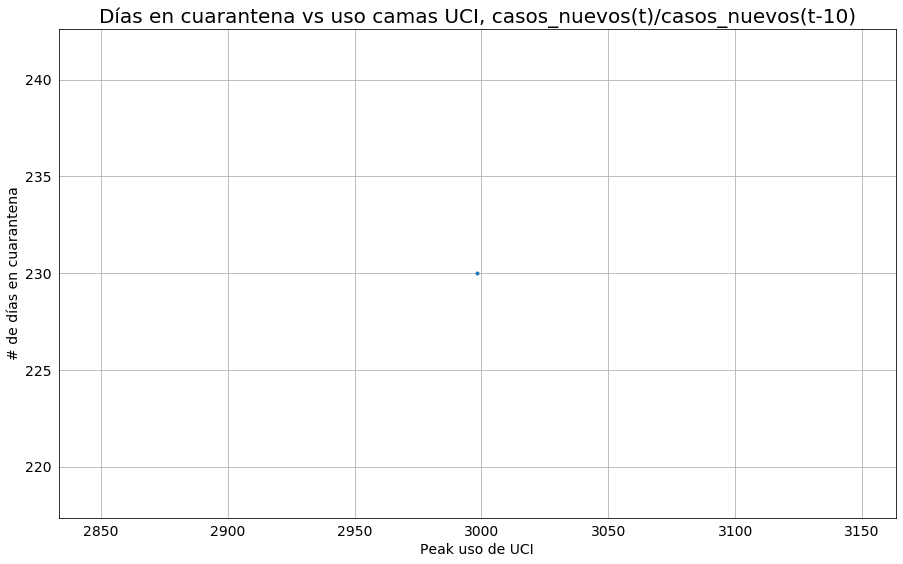

In [73]:
fig, ax = plt.subplots(len(dts), 1, figsize=(15,9*len(dts)), sharex=True, sharey=True, squeeze=False)
for j in range(len(dts)):
    i = 0
    ax[j,i].set_title('Días en cuarantena vs uso camas UCI, casos_nuevos(t)/casos_nuevos(t-%g)' % (dts[j],), fontsize=20)
    ax[j,i].plot(ucis[:,j], dias[:,j], ls='none', marker='.', c='tab:blue')
    ax[j,i].set_xlabel("Peak uso de UCI", fontsize=14)
    ax[j,i].set_ylabel("# de días en cuarantena", fontsize=14)
    ax[j,i].tick_params(bottom=False, top=False, left=False, right=False, labelsize=14)
    #ax[j,i].set_title('Días en cuarantena hasta %s' % epidemic.pred.index.max().strftime('%d-%m-%Y'), fontsize=20)
    ax[j,i].grid()

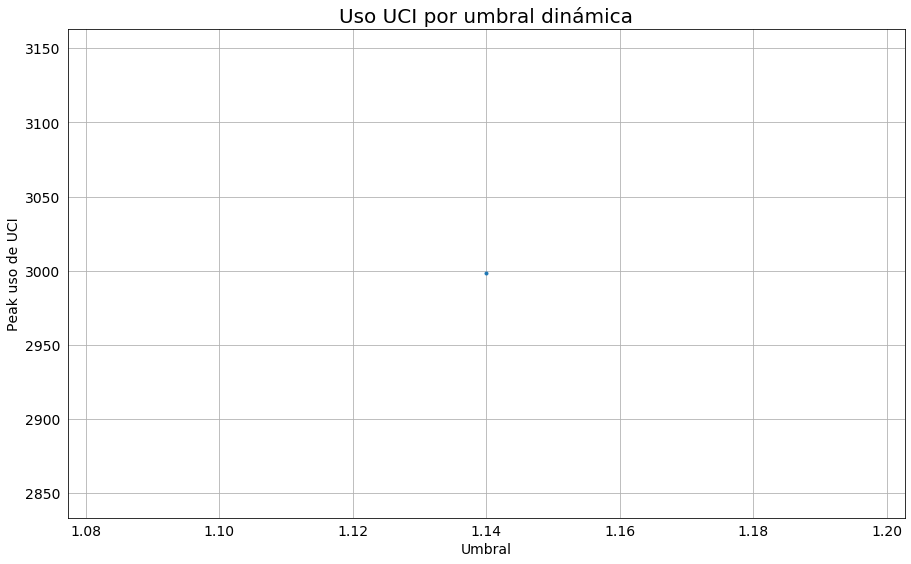

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(15,9), sharex=True, sharey=True, squeeze=False)
i, j = 0, 0
ax[j,i].set_title('Uso UCI por umbral dinámica', fontsize=20)
ax[j,i].plot(xs, ucis[:,0], ls='none', marker='.', c='tab:blue')
ax[j,i].set_xlabel("Umbral", fontsize=14)
ax[j,i].set_ylabel("Peak uso de UCI", fontsize=14)
ax[j,i].tick_params(bottom=False, top=False, left=False, right=False, labelsize=14)
ax[j,i].grid()